In [1]:
import pandas as pd
import arff
data_freq = arff.load('freMTPL2freq.arff')
df_freq = pd.DataFrame(data_freq, columns=["IDpol", "ClaimNb", "Exposure", "Area", "VehPower",
"VehAge","DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"])

In [2]:
data_sev = arff.load('freMTPL2sev.arff')
df_sev = pd.DataFrame(data_sev, columns=["IDpol", "ClaimAmount"]).groupby("IDpol").sum().reset_index()

Alles in ein einzelnes Dataframe, inkl. abhängiger Variable ClaimAmount (summiert pro Police) / Exposure

In [3]:
# Left join, weil es 6 Policen mit Schäden gibt, die nicht in df_freq erfasst sind
df = df_freq.merge(df_sev, on="IDpol", how='left')
df.fillna(0.0, inplace=True)
df["ClaimPerTime"] = df["ClaimAmount"] / df["Exposure"]

# Explorative Datenanalyse


In [4]:
df.describe()

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount,ClaimPerTime
count,6.780130e+05,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,6.780130e+05,6.780130e+05
mean,2.621857e+06,0.053247,0.528750,6.454631,7.044265,45.499122,59.761502,1792.422405,8.835998e+01,3.832608e+02
std,1.641783e+06,0.240117,0.364442,2.050906,5.666232,14.137444,15.636658,3958.646564,5.822454e+03,3.682070e+04
min,1.000000e+00,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000,0.000000e+00,0.000000e+00
25%,1.157951e+06,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000,0.000000e+00,0.000000e+00
50%,2.272152e+06,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000,0.000000e+00,0.000000e+00
75%,4.046274e+06,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000,0.000000e+00,0.000000e+00
max,6.114330e+06,16.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000,4.075401e+06,1.852455e+07



## Zusammenfassung
Insgesamt sehr sauberer Datensatz mit einigen Variablen, die mglw. bestimmte Zusammenhänge suggerieren (Alter, Dichte etc.). Nach einem recht oberflächlichen Blick lassen sich diese aber nur bedingt stützen; ein allzu einfaches Modell, das nur solche "offensichtlichen" Features mit einbezieht, ist also vmtl. nicht sinnvoll. Biases bzgl. einiger geographischer Regionen aufgrund von Ausreißern in den Schadenssummen pro Jahr. Automarken sind auch nicht gleichmäßig vertreten, mindestens eine Marke ist stark unterrepräsentiert. Abhängige Variable stark unbalanciert.

Das führt zu einem grundsätzlichen Problem z.B. bei Berechnung von Korrelationen: Abhängige Variable ist in 95% der Fälle gleich 0. Eine mögliche Lösung, um halbwegs brauchbare Korrelationen sichtbar zu machen: Einschränkung auf Level-Sets der Form {x | f(x) > c} für Grenzen c und Features f

Weitere Unklarheit: Wie historisch sind die Daten? D.h. ist der Bezugszeitraum immer der gleiche? Ggf. unvorhersehbare Confounder

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("darkgrid")

## (Komponenten der ) Abhängigen Variablen


### Versicherungszeiträume


,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount,ClaimPerTime
count,5.086640e+05,508664.000000,508664.000000,508664.000000,508664.000000,508664.000000,508664.000000,508664.000000,5.086640e+05,5.086640e+05
mean,2.795304e+06,0.047717,0.371583,6.522984,6.460870,44.041239,61.489583,1973.002908,8.966056e+01,4.827549e+02
std,1.680460e+06,0.229330,0.279372,2.114715,5.634356,13.653348,16.603849,4172.564494,6.665753e+03,4.250110e+04
min,1.000000e+00,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000,0.000000e+00,0.000000e+00
25%,1.195889e+06,0.000000,0.100000,5.000000,2.000000,33.000000,50.000000,105.000000,0.000000e+00,0.000000e+00
50%,3.007637e+06,0.000000,0.320000,6.000000,5.000000,43.000000,50.000000,458.000000,0.000000e+00,0.000000e+00
75%,4.075676e+06,0.000000,0.580000,7.000000,10.000000,53.000000,71.000000,2054.000000,0.000000e+00,0.000000e+00
max,6.114330e+06,16.000000,0.990000,15.000000,100.000000,100.000000,230.000000,27000.000000,4.075401e+06,1.852455e+07


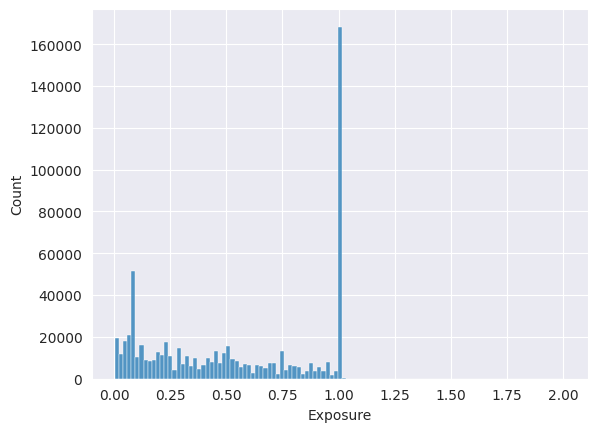

In [6]:
sns.histplot(df["Exposure"])
df[df["Exposure"] < 1].describe()

In [7]:
df[df["Exposure"] >= 1].describe()

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount,ClaimPerTime
count,1.693490e+05,169349.000000,169349.000000,169349.000000,169349.000000,169349.000000,169349.000000,169349.000000,169349.000000,169349.000000
mean,2.100885e+06,0.069856,1.000823,6.249325,8.796574,49.878080,54.570963,1250.022976,84.453516,84.415976
std,1.395615e+06,0.269257,0.016621,1.830755,5.394016,14.653276,10.720670,3170.841452,1506.247781,1506.166200
min,1.664200e+04,0.000000,1.000000,4.000000,0.000000,18.000000,50.000000,2.000000,0.000000,0.000000
25%,1.070174e+06,0.000000,1.000000,5.000000,5.000000,38.000000,50.000000,62.000000,0.000000,0.000000
50%,2.100773e+06,0.000000,1.000000,6.000000,8.000000,49.000000,50.000000,229.000000,0.000000,0.000000
75%,3.164288e+06,0.000000,1.000000,7.000000,12.000000,59.000000,51.000000,1064.000000,0.000000,0.000000
max,5.069180e+06,11.000000,2.010000,15.000000,100.000000,99.000000,196.000000,27000.000000,255013.030000,255013.030000


In [8]:
from IPython.display import Markdown
num = len(df[df["Exposure"] > 1])
display(Markdown(f"Nur {100*num/len(df_freq):.2f}% Versicherungen jenseits 1 Jahr"))

Nur 0.18% Versicherungen jenseits 1 Jahr

Sind Versicherungen, die nicht genau für ein Jahr laufen, in irgendeiner Weise aus Sicht der Geschäftlogik besonders? Unklar. 

### Akkumulierte Schadenssummen pro Zeitraum

Nur 3.7% der Policen haben überhaupt einen Schadensfall im Zeitraum

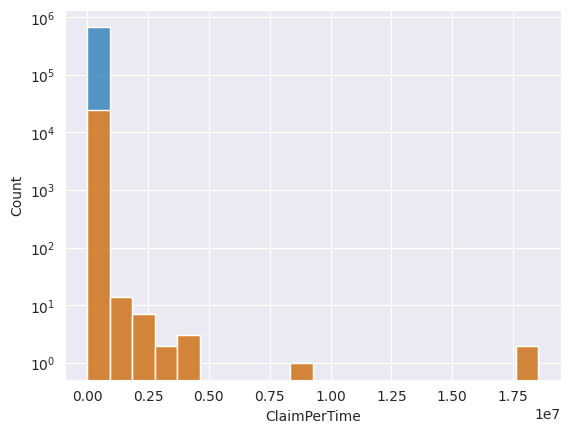

3


In [9]:
display(Markdown(f"Nur {100*len(df_sev)/len(df_freq):.1f}% der Policen haben überhaupt einen Schadensfall im Zeitraum"))
bins = 20

nz = df["ClaimPerTime"] > 0
sns.histplot(x=df["ClaimPerTime"], bins=bins,log=True)
sns.histplot(x=df[nz]["ClaimPerTime"], bins=bins,log=True)
plt.show()

print(len(df[df["ClaimPerTime"] > 7_500_000]["ClaimPerTime"]))
df = df[df["ClaimPerTime"] < 7_500_000]

Es gibt Ausreißer, die die Modellierung falsch bzw. "unfair" (i.S.d. Aufgabenstellungen) beeinflussen könnten. Das sind Policen mit zusammen 36Mio. € Schäden auf das Jahr gerechnet (also vmtl. hohe Schäden bei Policen mit kurzen Laufzeiten), also grob 15% der gesamten jährlichen Schadenssumme. Könnten im finalen Preismodell, das beim Kunden ankommt, mglw. einfach als Durchschnitt auf die restlichen Werte umgelegt werden (hier nicht getan)

## Grundlegende Zusammenhänge


Es gibt einige plausible vorläufige Hypothesen über den Zshg. zwischen abhängiger Variable und den unabhängigen Variablen, die man auf den gegebenen Daten vermuten könnte. Ein paar davon sind im Folgenden dargestellt.

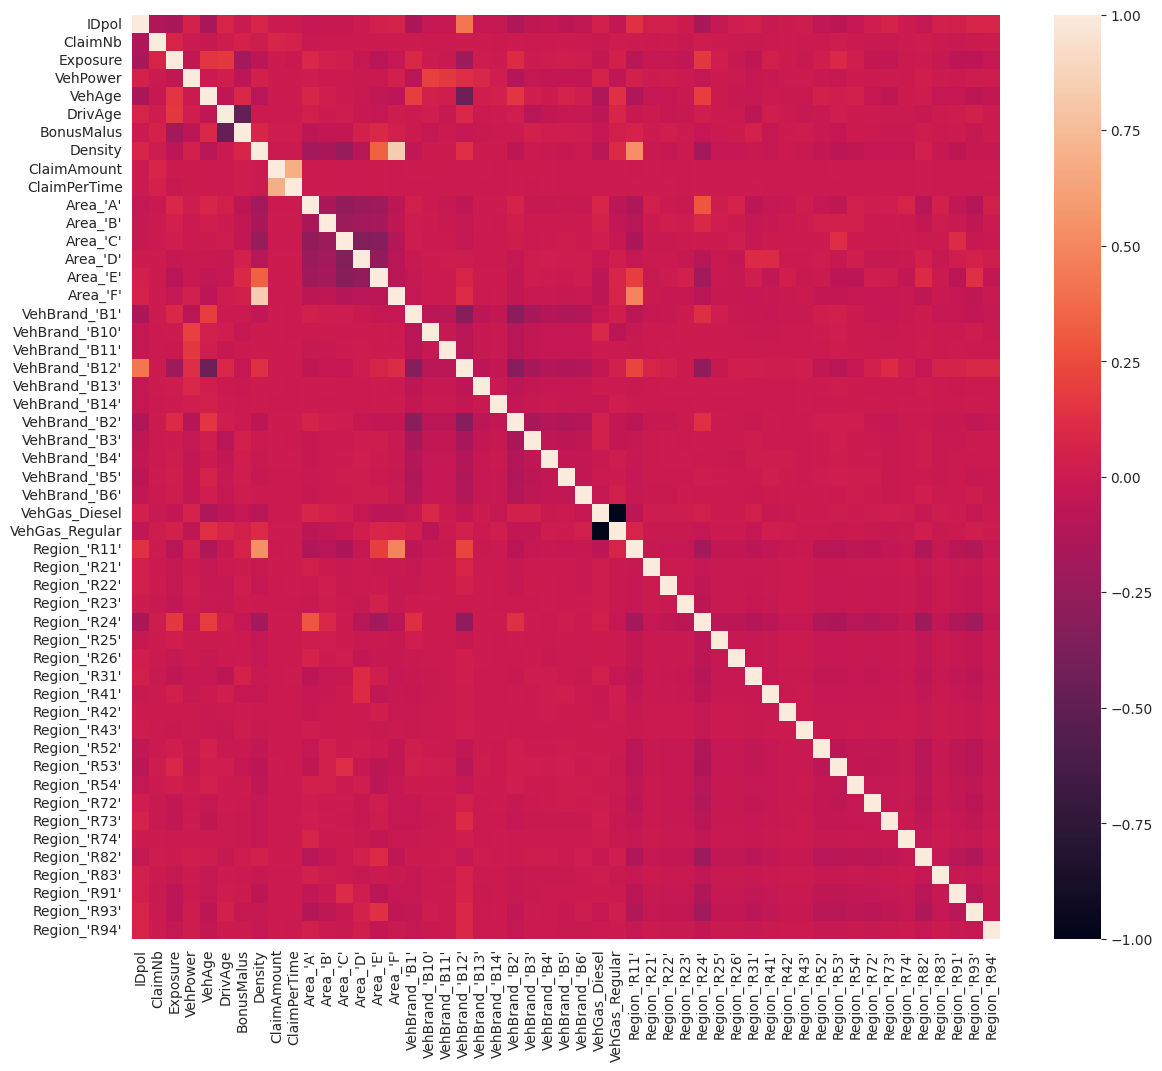

In [10]:
df_onehot = pd.get_dummies(df, columns=["Area", "VehBrand", "VehGas", "Region"])
ax, fig = plt.subplots(figsize=[14,12])
sns.heatmap(df_onehot.corr())
plt.show()

Durch kategorische Features mit vielen Werten sehr hochdimensional, abhängige Variable scheint durchgehend bei 0 korreliert (siehe Begründung oben). Daher mit cutoff bei mind. 500k:

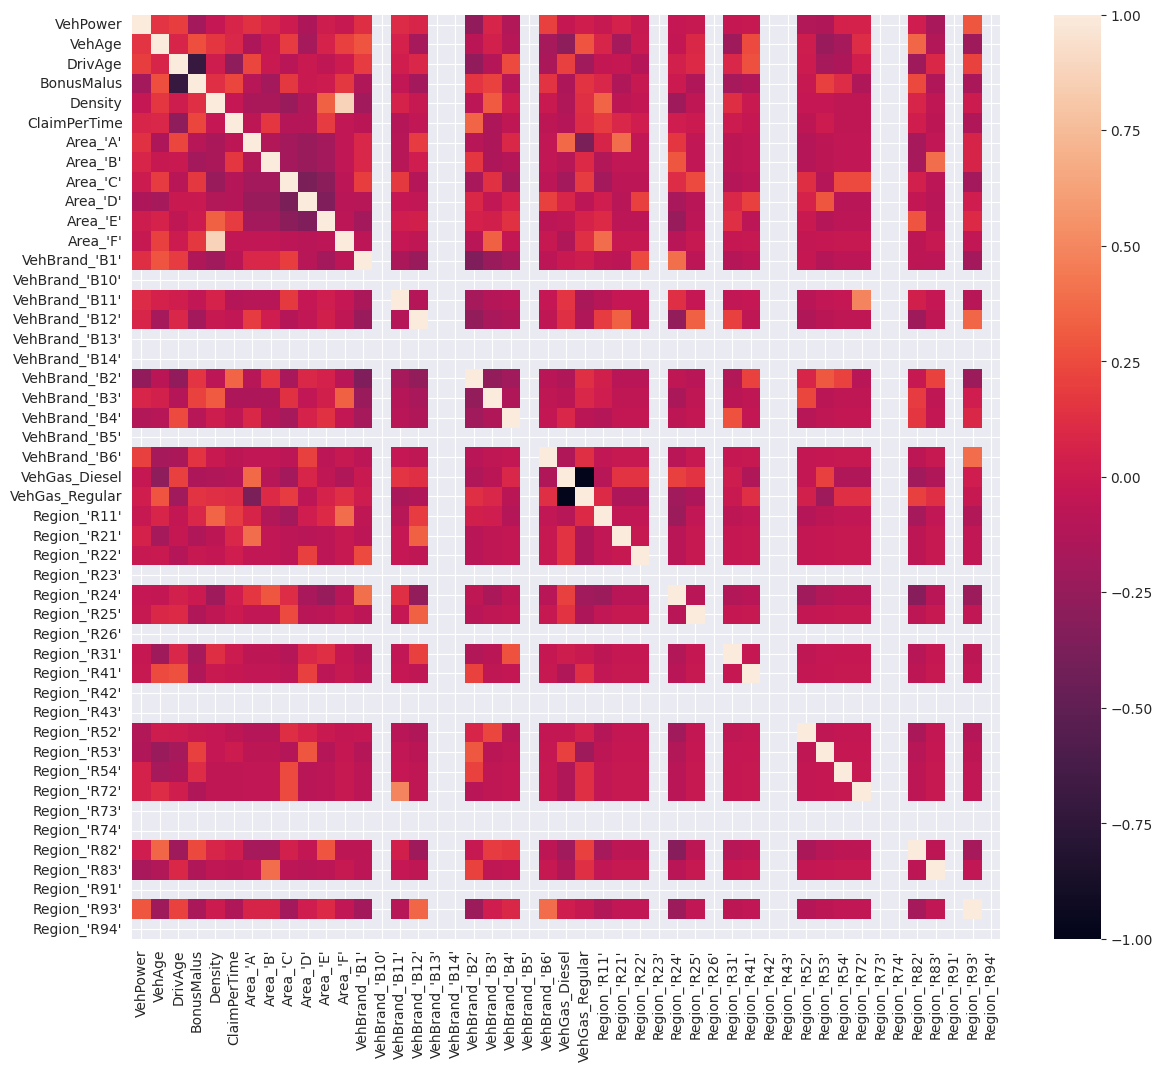

In [11]:
df_onehot = pd.get_dummies(df, columns=["Area", "VehBrand", "VehGas", "Region"])
df_onehot = df_onehot[df_onehot["ClaimPerTime"] > 500_000].drop(columns=["IDpol","ClaimNb","Exposure", "ClaimAmount"])
ax, fig = plt.subplots(figsize=[14,12])
sns.heatmap(df_onehot.corr())
plt.show()

### Claim/Exposure vs Alter des Fahrers
Junge Fahrer neigen dazu, risikoreicher zu fahren, was zu Unfällen mit hohen Schadenssummen führt.

Lineare Korrelation: -0.28

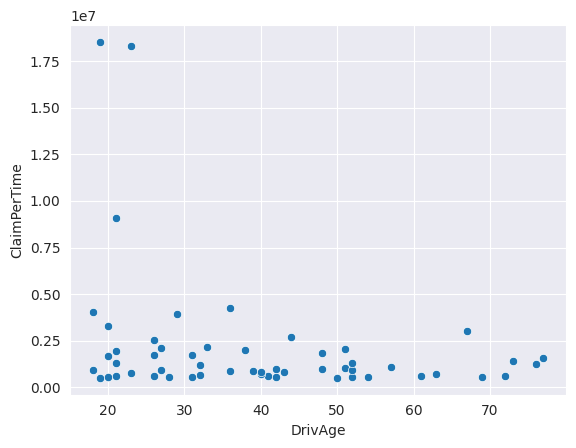

Lineare Korrelation: -0.01

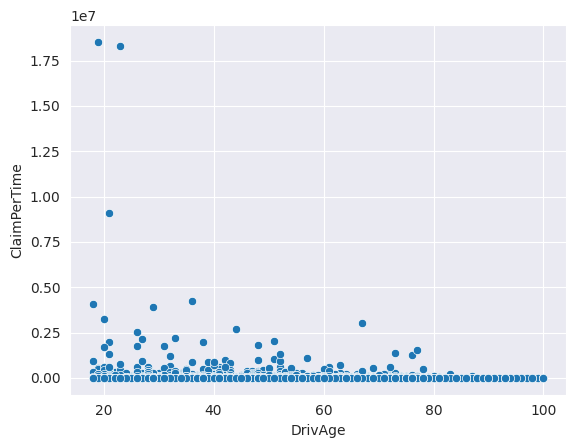

In [12]:
from scipy.stats import pearsonr   

nz = df["ClaimPerTime"] > 500_000
x = df[nz]["DrivAge"]
y = df[nz]["ClaimPerTime"]
display(Markdown(f"Lineare Korrelation: {pearsonr(x,y).statistic:.2f}"))
sns.scatterplot(x=x, y=y)
plt.show()

x = df["DrivAge"]
y = df["ClaimPerTime"]
display(Markdown(f"Lineare Korrelation: {pearsonr(x,y).statistic:.2f}"))
sns.scatterplot(x=x, y=y)
plt.show()

Bleibt als leichte Korrelation sichtbar, wenn man sich auf höhere Schadenssummen einschränkt. Nicht überzeugend. Altersverteilung im Datensatz:

<Axes: xlabel='DrivAge', ylabel='Count'>

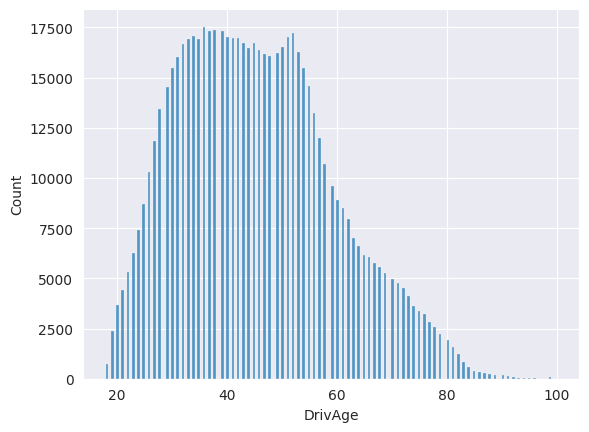

In [13]:
sns.histplot(df["DrivAge"])

Ohne Vergleichsdaten schwer einzuschätzen, wie repräsentativ das ist, wirkt auf mich aber plausibel für die Populationsverteilung.


### Claim/Exposure vs BonusMalus
Mögliche Erwartung: Höherer Malus geht automatisch mit hohen Schadenssummen einher.

Lineare Korrelation: 0.13

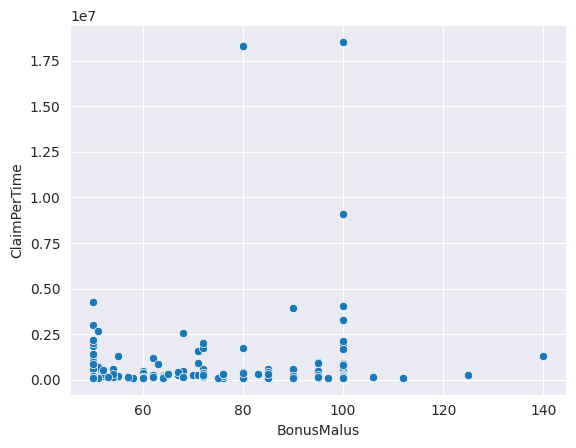

Lineare Korrelation: 0.01

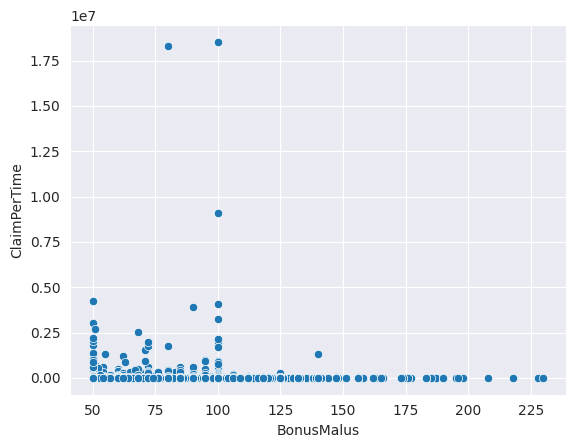

In [14]:
from scipy.stats import pearsonr  

nz = df["ClaimPerTime"] > 100_000 
x = df[nz]["BonusMalus"]
y = df[nz]["ClaimPerTime"]

display(Markdown(f"Lineare Korrelation: {pearsonr(x,y).statistic:.2f}"))
sns.scatterplot(x=x, y=y)
plt.show()

x = df["BonusMalus"]
y = df["ClaimPerTime"]

display(Markdown(f"Lineare Korrelation: {pearsonr(x,y).statistic:.2f}"))
sns.scatterplot(x=x, y=y)
plt.show()

Bleibt zwar auch tendenziell bestehen, ist aber nicht deutlich. Grund mglw. Art der Berechnung: Pro unfallfreiem Jahr Reduktion um Faktor 0.95, zu Beginn 1, aber minimal 0.5. D.h. Fahranfänger haben Bonus/Malus 1, außerdem cutoff/Sättigung bei 0.5 nach 13 Jahren (d.h. Senioren haben ggf. Bonus 0.5), und 0.5 ist "sticky" (ändert sich erst beim zweiten Unfall wieder nach oben). In die andere Richtung erzeugt *jeder* Unfall, unabhängig von Schadenshöhe, bei eigenem Verschulden einen Malus von 1.25. D.h. viele kleine Unfälle aus Unachtsamkeit führen zu hohen Maluswerten bei niedrigen Schadenssummen.

### Claim/Exposure vs Density
Mögliche Erwartung: Höhere Bevölkerungsdichte führt zu höheren Schadenssummen. Scheint nicht haltbar. Korrelationskoeffizient bei 0.01.

Lineare Korrelation: -0.04

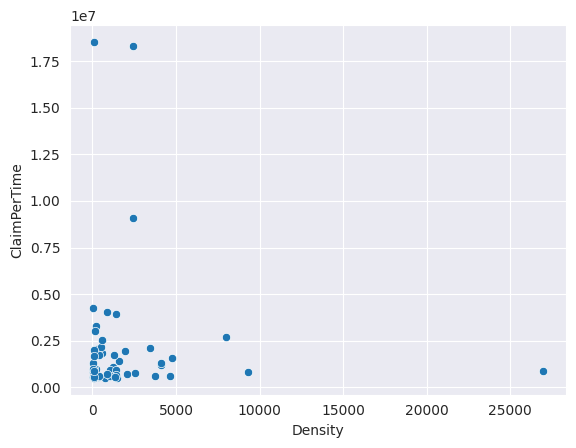

Lineare Korrelation: -0.00

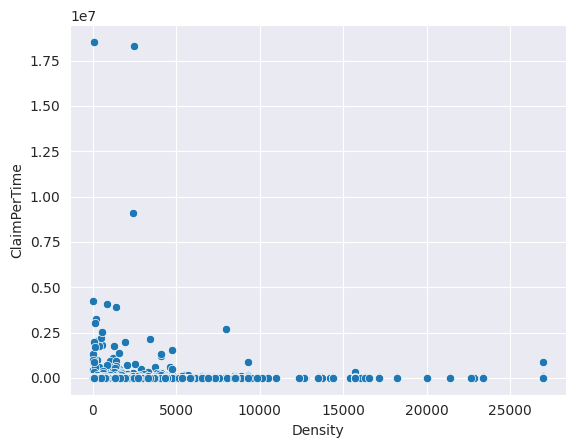

In [15]:
from scipy.stats import pearsonr   

nz = df["ClaimPerTime"] > 500_000 
x = df[nz]["Density"]
y = df[nz]["ClaimPerTime"]
display(Markdown(f"Lineare Korrelation: {pearsonr(x,y).statistic:.2f}"))
sns.scatterplot(x=x, y=y)
plt.show()

x = df["Density"]
y = df["ClaimPerTime"]
display(Markdown(f"Lineare Korrelation: {pearsonr(x,y).statistic:.2f}"))
sns.scatterplot(x=x, y=y)
plt.show()

Das scheint nicht haltbar. Mögliche Erklärungen: Schwere Unfälle am Land (Landstraßen, hohe Geschwindigkeiten), im Gegensatz zu leichteren Unfällen in der Stadt (<50km/h). Korrelationskoeffizient bei effektiv 0. Density-Verteilung:

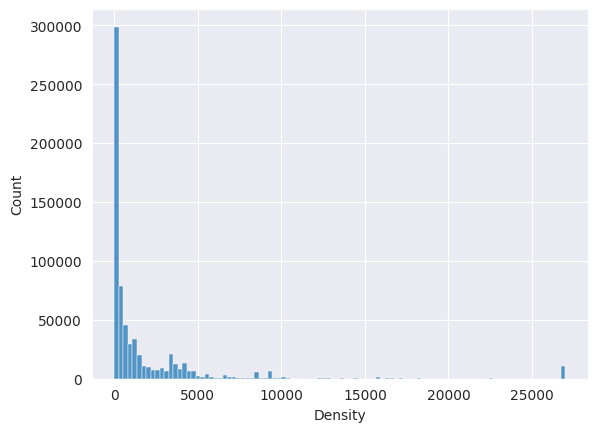

In [16]:
sns.histplot(df["Density"], bins=100)
plt.show()

Könnte eine klassische Power-Law-Verteilung sein, hauptsächlich dünn besiedelte Gebiete im Datensatz. Reflektiert vmtl. Populationsverteilung in Frankreich gut. (Paris etc. ganz rechts)

### Claim/Exposure vs VehPower 
Erwartung: Mehr Power -> schlimmere / mehr Unfälle? Power hier kategorisch, wg. fehlener Spezifikation nehmen wir einmal eine lineare Abbildung zwischen Kategorien und PS-Werten an.

Lineare Korrelation: 0.26

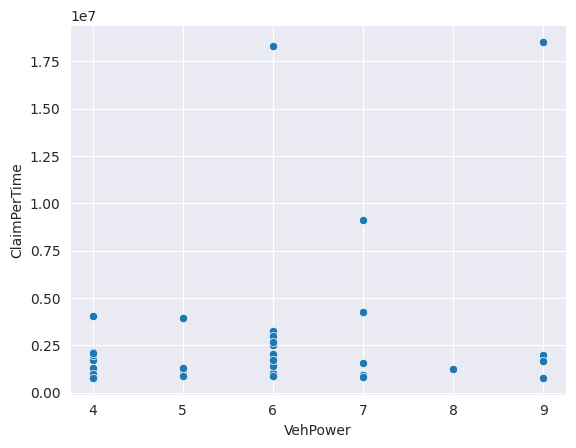

Lineare Korrelation: 0.00

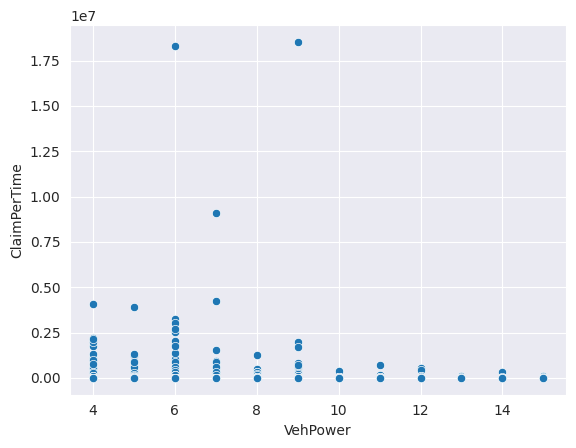

In [17]:
nz = df["ClaimPerTime"] > 750_000 
x = df[nz]["VehPower"]
y = df[nz]["ClaimPerTime"]
display(Markdown(f"Lineare Korrelation: {pearsonr(x,y).statistic:.2f}"))
sns.scatterplot(x=x, y=y)
plt.show()

x = df["VehPower"]
y = df["ClaimPerTime"]
display(Markdown(f"Lineare Korrelation: {pearsonr(x,y).statistic:.2f}"))
sns.scatterplot(x=x, y=y)
plt.show()

Allenfalls leichte Tendenz, auch wieder nur sichtbar 'an den Rändern' in Fällen über einer gewissen Schadensgrenze.

### Claim/Exposure vs geographische Information

#### Nach Region

Durchschnittliche Schadenswerte pro Region pro Zeitraum.


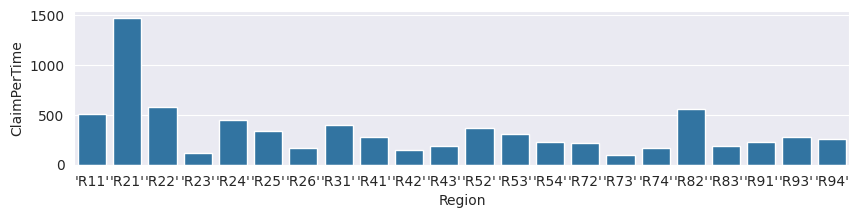

In [18]:
regions = df.groupby("Region")["ClaimPerTime"].mean()
fig, ax = plt.subplots(figsize=[10,2])
sns.barplot(regions)
plt.show()

Histrogramm zu Verteilung der Regionen

<Axes: xlabel='Region', ylabel='Count'>

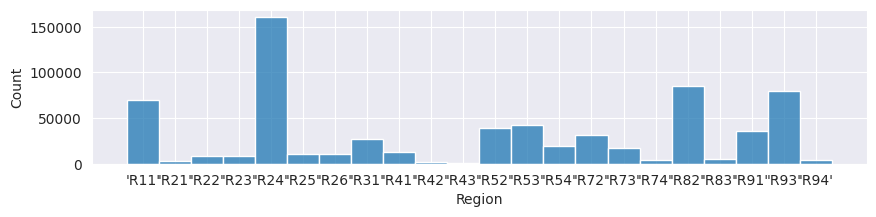

In [19]:
fig, ax = plt.subplots(figsize=[10,2])
sns.histplot(df["Region"].sort_values(ascending=True))

Region 21 (offenbar Champagne, lt. Wikipedia) liegt mehr als zwei Standardabweichungen über dem Mittel. Mglw. irgendwie geographisch erklärbar? Kombinierter Durchgangsverkehr aus England und Rest von Europa? Der ganze Champagner? Etwas mysteriös. Plausiblere Erklärung: R21 ist eine der am wenigsten vertretenen Regionen -> extreme Ergebnisse wahrscheinlicher. Blick in Region 21:

<Axes: ylabel='ClaimPerTime'>

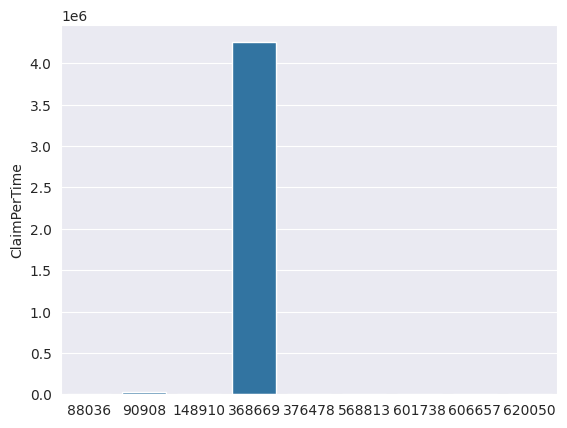

In [20]:
df21 = df[df["Region"] == "'R21'"]
df21 = df21[df21["ClaimPerTime"] > 5000]
sns.barplot(df21["ClaimPerTime"])

R21 hat also einen einzigen, sehr teuren Schadensfall, der hier als Ausreißer den Schnitt der gesamten Region verändert. Das ist höchstwahrscheinlich nicht repräsentativ, und macht bspw. Regression deutlich instabiler. Würde daher R21 aus den Daten ausschließen.


Eyeballing suggeriert außerdem, dass Regionen in drei oder vier Cluster geteilt sind (ohne Ausreißer, zwei oder drei):

106567.51265702472


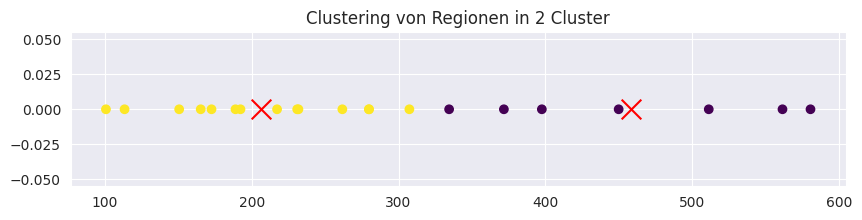

44507.68509561349


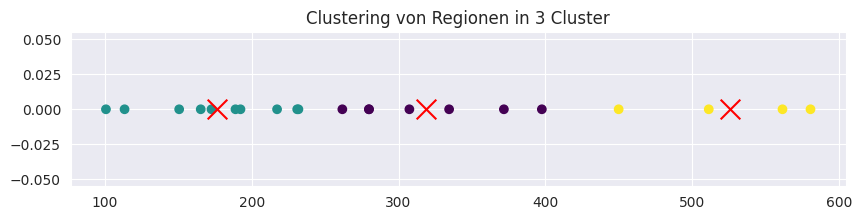

KMeans(n_clusters=3, random_state=0)

In [21]:

from sklearn.cluster import KMeans

def cluster(n_clusters, data, desc = None):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0,)
    kmeans.fit(data)

    plt.figure(figsize=(10, 2))
    plt.scatter(data, np.zeros_like(data), c=kmeans.labels_, cmap='viridis')

    # Mark the cluster centers
    for center in kmeans.cluster_centers_:
        plt.scatter(center, 0, s=200, c='red', marker='x')

    plt.title(f"Clustering von {desc} in {n_clusters} Cluster")
    print(kmeans.inertia_)
    plt.show()

    return kmeans

def cluster_regions(n_clusters):
    data = np.array(regions[regions < 1400]).reshape(-1, 1)
    return cluster(n_clusters,data,"Regionen")

cluster_regions(2)
cluster_regions(3)

Obige Cluster wären eine Möglichkeit, die Regionen manuell neu zu unterteilen (siehe Feature Engineering).

#### Nach Area-Codes
Grundsätzlich: Ein wenig Googeln bringt mich zum Schluss, dass Area-Codes vmtl. die Startziffern der Telefonvorwahlen o.ä. meint.

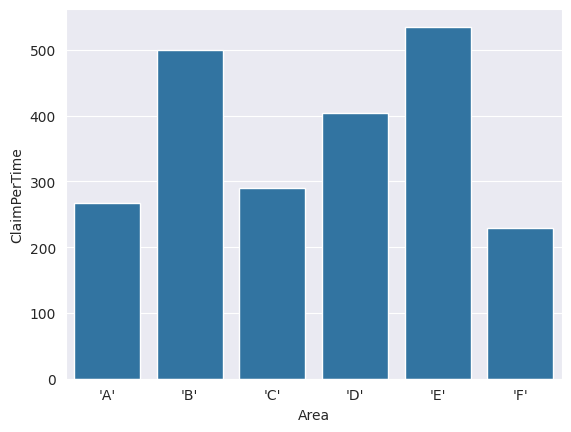

In [22]:
areas = df.groupby("Area")["ClaimPerTime"].mean()
sns.barplot(areas)
plt.show()

Mir ist nicht klar, was ein Area-Code ist, weil ein bisschen herumstochern suggeriert, dass bestimmte Regionen in allen Area-Codes besonders stark vertreten sind, ansonsten aber kein offensichtlicher Zshg. zw. Region und Area-Code besteht. Region 'F' ist allerdings ausschließlich Paris / Ile-de-France, was zu Telefonnummern nur bedingt passt:

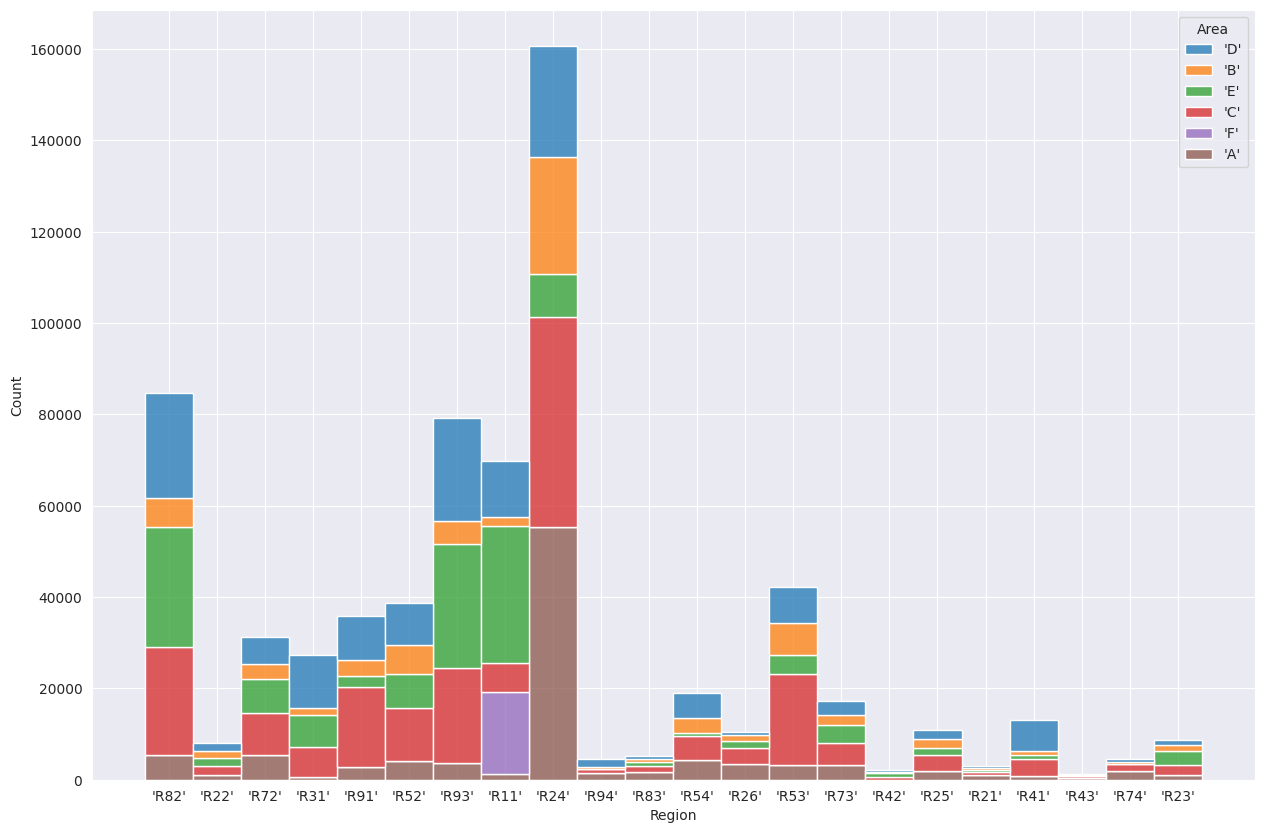

<Axes: xlabel='Area', ylabel='Count'>

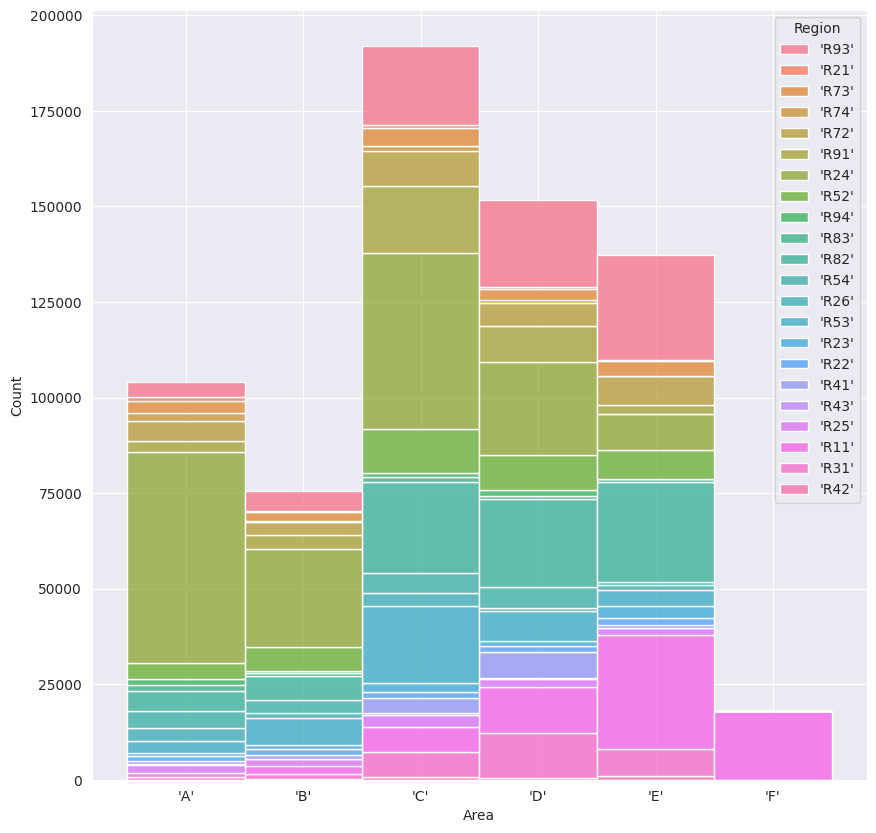

In [23]:
plt.subplots(figsize=[15,10])

area_df = df[["Area", "Region"]]
sns.histplot(area_df, stat="count", multiple="stack",
             x="Region", kde=False,
             hue="Area",
             element="bars", legend=True)
plt.show()

plt.subplots(figsize=[10,10])
sns.histplot(area_df.sort_values(by="Area"), stat="count", multiple="stack",
             x="Area", kde=False, hue="Region",
             element="bars", legend=True)

Auch hier würde ich die 6 Ausprägungen auf weniger reduzieren, meiner Ansicht nach bieten sich zwei an.

11153.624313618548


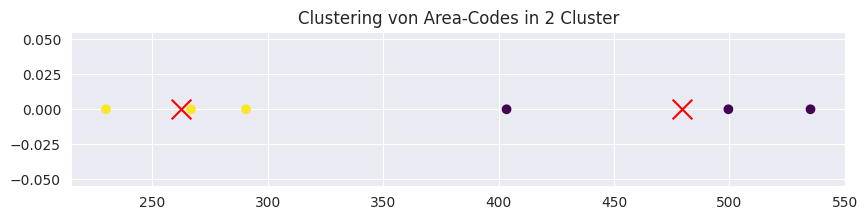

KMeans(n_clusters=2, random_state=0)

In [24]:
def cluster_areas(n_clusters):
    data = np.array(areas).reshape(-1, 1)
    return cluster(n_clusters,data,"Area-Codes")

cluster_areas(2)

### Diesel vs Benziner

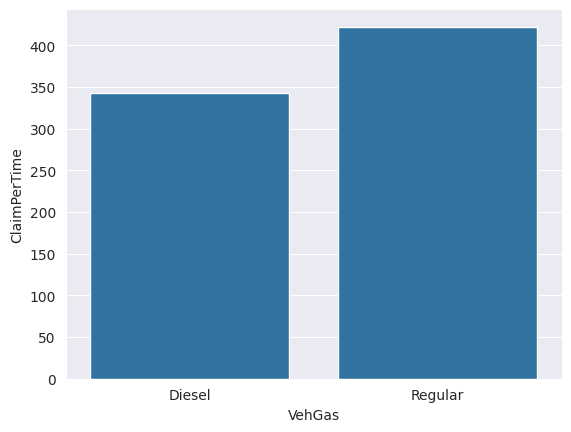

In [25]:
gas = df.groupby("VehGas")["ClaimPerTime"].mean()
sns.barplot(gas)
plt.show()

#### Automarke

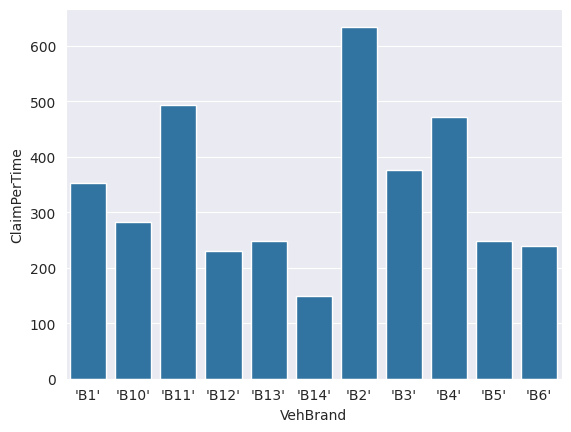

In [26]:
brands = df.groupby("VehBrand")["ClaimPerTime"].mean()
sns.barplot(brands)
plt.show()

Könnte relevant sein. Deutliche Unterschiede zwischen den Marken. 12 Ausprägungen sind recht viel, würde erneut clustern.

51835.02127461981


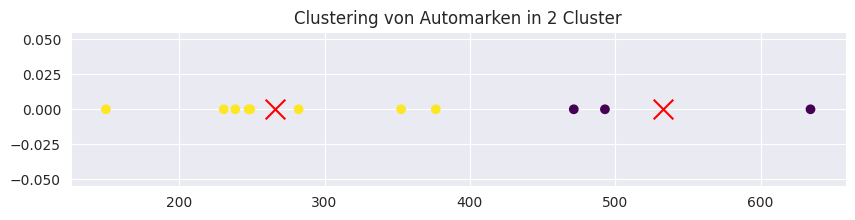

KMeans(n_clusters=2, random_state=0)

In [27]:
def cluster_brands(n_clusters):
    data = np.array(brands).reshape(-1,1)
    return cluster(n_clusters=n_clusters,data=data, desc="Automarken")

cluster_brands(2)

<Axes: xlabel='VehBrand', ylabel='Count'>

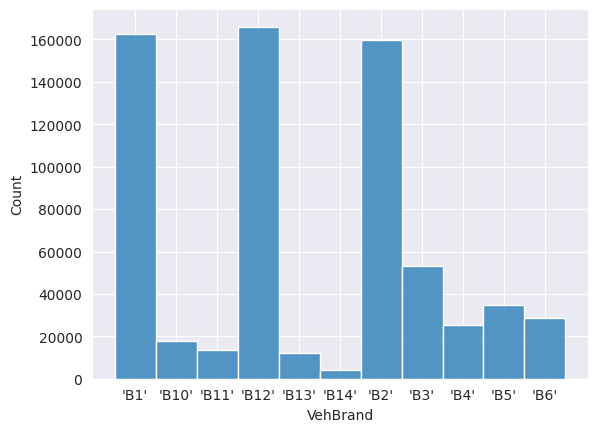

In [28]:
sns.histplot(df["VehBrand"].sort_values())

Auch hier ist mit B14 wieder Vorsicht geboten wg Samplegröße

# Feature Engineering

Ziel ist laut Aufgabe, ein "faires" Modell zu bauen. Das kann viel heißen, ich vermute aber insbesondere dass man an einer Lösung interessiert ist, die den Versicherungsnehmern, d.h. Kunden ggü. "explainable" ist. Eine Möglichkeit in diese Richtung wäre, z.B. eine händische Aufteilung zunächst nach Region vorzunehmen, und dann ein komplexeres Modell einzusetzen. Dazu würde ich die Regionen, Areas und Automarken in neue Cluster zusammenfassen, und darüber hinaus auf komplexere Transformationen des Feature-Raums etwa durch PCA o.ä. zunächst verzichten, und stattdessen reine Feature Selection betreiben. Insbes. spielt für explainability auch Komplexität eine Rolle; eine Reduktion des Feature-Raums ist also mglw. wünschenswert.

Kategorische Daten werden in one-hot-Darstellung konvertiert (VehPower lassen wir hierbei außen vor, siehe Überlegungen im vorigen Teil). Zum Trainieren eines Modells müssen unabhängige Variablen maskiert werden, die zur prediction nicht verfügbar sind: Exposure, ClaimNb und ClaimAmount. Für bspw. lineare Regression mglw. auch Dimensionsreduktion (s.o.) von kategorischen Variablen notwendig.

44507.68509561349


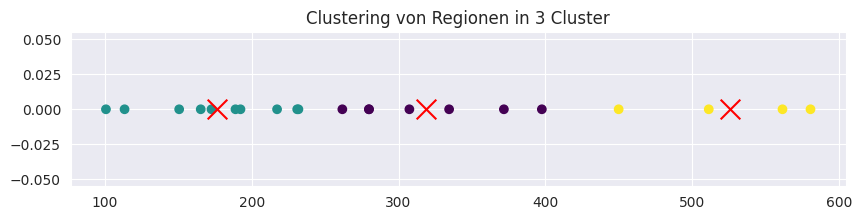

24216.867222365807


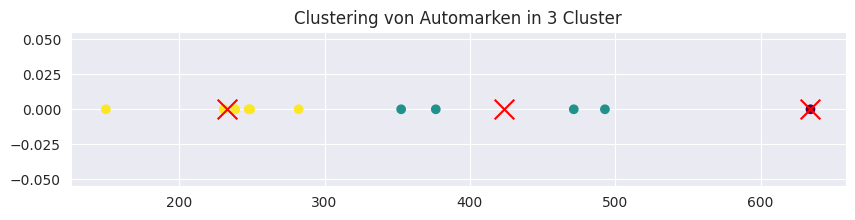

11153.624313618548


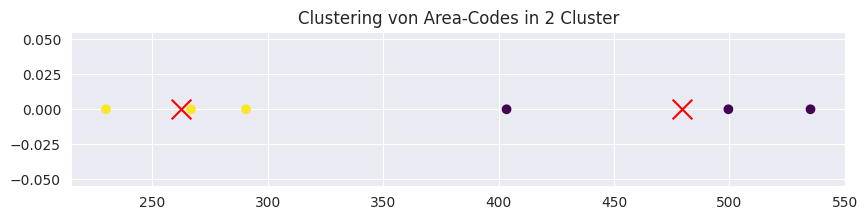

/tmp/ipykernel_277358/359534470.py:24: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_engineered = df_engineered.mask(df_engineered.dtypes == bool, df_engineered.astype(int))


Index(['IDpol', 'ClaimNb', 'Exposure', 'VehPower', 'VehAge', 'DrivAge',
       'BonusMalus', 'Density', 'ClaimAmount', 'ClaimPerTime', 'Area_0',
       'Area_1', 'VehBrand_0', 'VehBrand_1', 'VehBrand_2', 'Region_0',
       'Region_1', 'Region_2', 'VehGas_Regular'],
      dtype='object')


In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

new_regions = cluster_regions(3)
region_data = regions[regions < 1400]
region_mapping = {k : str(v) for (k,v) in zip(region_data.index,new_regions.labels_)}

new_brands = cluster_brands(3)
brand_data = brands
brand_mapping = {k : str(v) for (k,v) in zip(brand_data.index,new_brands.labels_)}

new_areas = cluster_areas(2)
area_data = areas
area_mapping =  {k : str(v) for (k,v) in zip(area_data.index,new_areas.labels_)}

df_dimred = df.drop(df[df["Region"] == "'R21'"].index)
df_dimred["VehBrand"] = df_dimred["VehBrand"].map(lambda k: brand_mapping[k])
df_dimred["Region"] = df_dimred["Region"].map(lambda k: region_mapping[k])
df_dimred["Area"] = df_dimred["Area"].map(lambda k: area_mapping[k])

df_engineered = pd.get_dummies(df_dimred, columns=["Area", "VehBrand", "Region"])
df_engineered =  pd.get_dummies(df_engineered, columns=["VehGas"], drop_first=True)
df_engineered = df_engineered.mask(df_engineered.dtypes == bool, df_engineered.astype(int))
print(df_engineered.columns)

# Modellvergleich
Wie oben bemerkt: Softe Kriterien wie Interpretierbarkeit spielen eine Rolle. Darüber hinaus: Korrekte Prädiktion ist nicht unbedingt alleiniges Kriterium. Ein Prädiktor, der für jeden der 6 Mio. Kunden auch nur um einen einzelnen Euro Schaden im Jahr zu niedrig schätzt, ist geschäftlich nicht verkraftbar. 
Regressions-Kostenfunktion sollte an sich aber robust ggü. Ausreißern sein, die im Datensatz vorhanden sind. Andererseits soll der triviale Schätzer, der immer (fast) 0 ausgibt vermieden werden; i.A. ist also auch niedrige Varianz erwünscht, weil zu große Preisunterschiede zw. Kunden schwer vermittelbar sind. 

### Least-Squares Regression
Zusammenhänge scheinen nicht sonderlich linear zu sein, viele Entscheidungsvariablen im Modell. Koeffizienten leicht interpretierbar. Einfach modifizierbar um penalty für Unterschätzung zu inkorporieren. Liefert mglw. negative Ergebnisse (-> nicht-negative Regression). Minimiert Varianz.

### Entscheidungsbaumregression
Sehr gut interpretierbar (bei begrenzter Tiefe), kommt mit nicht-linearen Zusammenhängen zurecht. Allerdings schwer modifizierbar, falls schließlich unterschätzt wird. Wird aber vmtl. Versicherungsbeiträge von 0 für die meisten Kunden liefern, was ggf. aus geschäftlicher Sicht nicht wünschenswert ist.

### Neuronales Netz
Nicht interpretierbar, gut für nicht-lineare Zusammenhänge, leicht adaptierbar.

## Entscheidung
Gegeben die verschiedenen Kriterien (Interpretierbarkeit, Güte der Schätzung, niedrige Varianz, keine negativen Werte) scheint nicht-negative OLS das geeignetste Modell.


Index(['IDpol', 'ClaimNb', 'Exposure', 'VehPower', 'VehAge', 'DrivAge',
       'BonusMalus', 'Density', 'ClaimAmount', 'ClaimPerTime', 'Area_0',
       'Area_1', 'VehBrand_0', 'VehBrand_1', 'VehBrand_2', 'Region_0',
       'Region_1', 'Region_2', 'VehGas_Regular'],
      dtype='object')
Decision Tree regression...


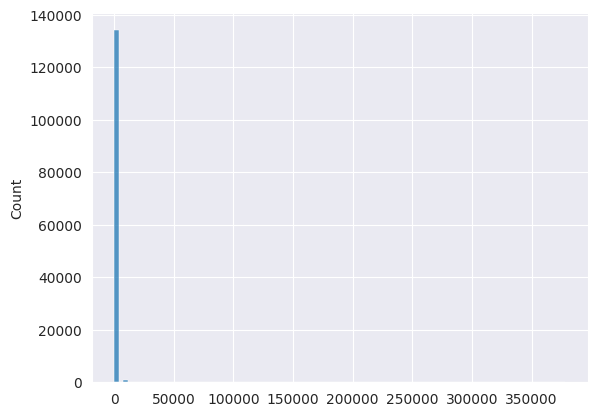

Mean Absolute Error: 27.070230782612885
Yield:  -0.6674288171073409
The binary tree structure has 15 nodes and has the following tree structure:

 0 split at 378.0: 1 if DrivAge <= 19.5 else 8.
	 1 split at 10878.2: 2 if VehPower <= 8.5 else 5.
		 2 split at 3540.3: 3 if DrivAge <= 18.5 else 4.
			 3 leaf with value=10497.4.
			 4 leaf with value=1415.3.
		 5 split at 84842.2: 6 if Density <= 93.5 else 7.
			 6 leaf with value=378304.4.
			 7 leaf with value=3601.3.
	 8 split at 329.1: 9 if DrivAge <= 23.5 else 12.
		 9 split at 2799.3: 10 if Density <= 2413.0 else 11.
			 10 leaf with value=1066.9.
			 11 leaf with value=10719.6.
		 12 split at 254.8: 13 if BonusMalus <= 88.5 else 14.
			 13 leaf with value=228.0.
			 14 leaf with value=615.7.


In [33]:
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import HuberRegressor

data = df_engineered[df_engineered["ClaimPerTime"] >= 0]
print(data.columns)
# Features and target
X = data.drop(columns=["IDpol","ClaimNb","Exposure", "ClaimAmount", "ClaimPerTime"])
y = data['ClaimPerTime']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42000)

dt_regressor = DecisionTreeRegressor(random_state=10, criterion="squared_error", max_depth=3)

print("Decision Tree regression...")
dt_regressor.fit(X_train, y_train)
y_pred = dt_regressor.predict(X_test)

sns.histplot(y_pred, bins=100)
plt.show()

print("Mean Absolute Error:", np.sqrt(mean_absolute_error(y_test,y_pred)))
print("Yield: ", (y_pred - y_test).mean())

clf = dt_regressor

# Aus den sklearn-docs
n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold
values = clf.tree_.value

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space} {node} leaf with value={value:.1f}.".format(
                space=node_depth[i] * "\t", node=i, value=values[i][0][0]
            )
        )
    else:
        print(
            "{space} {node} split at {value:.1f}: "
            "{left} if {feature} <= {threshold} "
            "else {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=X_train.columns[feature[i]],
                threshold=threshold[i],
                right=children_right[i],
                value=values[i][0][0],
            )
        )



Linear regression...


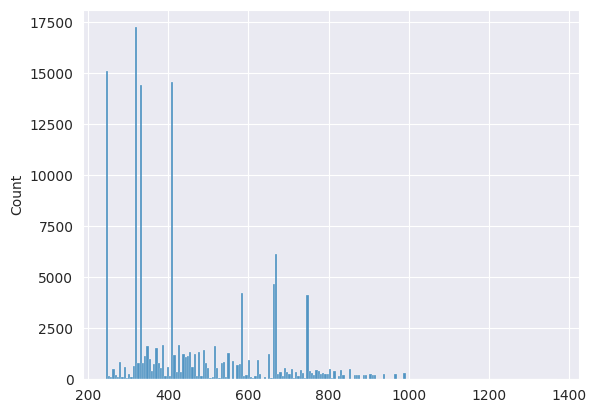

Regression Error: 28.283279257819586
Yield:  74.14609010123837
Intercept: 0.0
VehPower: 0.00
VehAge: 0.00
DrivAge: 0.00
BonusMalus: 4.86
Density: 0.00
Area_0: 77.65
Area_1: 0.00
VehBrand_0: 339.69
VehBrand_1: 0.00
VehBrand_2: 0.00
Region_0: 0.00
Region_1: 0.00
Region_2: 86.20
VehGas_Regular: 0.00


In [31]:

from scipy import stats

linear_regressor = LinearRegression(positive=True, fit_intercept = False)

print("Linear regression...")
# Perform 5-fold cross-validation
linear_regressor.fit(X_train, y_train)
y_pred = linear_regressor.predict(X_test)

sns.histplot(y_pred,bins=200)
plt.show()
# Evaluation Metrics
print("Mean Absolute Error:", np.sqrt(mean_absolute_error(y_test,y_pred)))
print("Yield: ", (y_pred - y_test).mean())
print("Intercept:", linear_regressor.intercept_)
for label, coef in zip(X.columns, linear_regressor.coef_):
    print(f"{label}: {coef:.2f}")


## Auswertung
Beide Modelle erreichen sehr ähnliche Performance und sind ähnlich gut interpretierbar. Allerdings liefert nicht-negative Regression ein glatteres Ergebnis mit niedrigerer Varianz (sozusagen per Definition) und wäre daher aus meiner Sicht zu bevorzugen. 

Aus den Koeffizienten wie aus den Knoten des Entscheidungsbaumes lässt sich ablesen, dass der Bonus/Malus, wie mglw. erwartet, trotz den genannten Problem mit dieser Variable als Komponente des Prädiktors eine Rolle spielt, offenbar aber vor allem Region/Area und Automarke stark mit dem zu erwartenden Schaden korrelieren. Es ist möglicherweise der Nicht-Negativitäts-Constraint und ggf. Nichtlinearität der Zusammenhänge geschuldet, dass DrivAge und Density dort außen vor bleiben, aber im Entscheidungsbaum wichtig sind.

### Weitere Optimierungen
Es wäre ggf. notwendig, stärker auf eine Angleichung der Verteilung in den Daten auf die Verteilung innerhalb der Kundschaft zu achten, um bessere Generalisierung zu erreichen. Das betrifft insbesondere regionale Unterschiede sowie Automarken, die beide letztlich eine starke Rolle in der Vorhersage spielen, von denen aber auch nicht klar ist, inwiefern sie im Datensatz unbiased repräsentiert sind. Unter Inkaufnahme fehlender Interpretierbarkeit und bei größerem Datensatz würde sich auch ein tiefes neuronales Netz anbieten, ich würde aber bei dem gegebenen Datensatz keine signifikante Steigerung der Genauigkeit erwarten.